header files

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal
from sys import float_info

plot_config

In [ ]:
# Set options to display numbers without scientific notation in numpy arrays
np.set_printoptions(suppress=True)

# Configure global plotting settings for better visualization consistency across plots

plt.rc('axes', titlesize=20)    # Font size of the title of axes
plt.rc('font', size=24)         # General font size
plt.rc('axes', labelsize=18)    # Font size of x and y labels
plt.rc('xtick', labelsize=16)   # Font size of x-axis tick labels
plt.rc('ytick', labelsize=16)   # Font size of y-axis tick labels
plt.rc('legend', fontsize=14)   # Font size of legend text
plt.rc('figure', titlesize=24)  # Font size of figure title

data_processing

The function simplifies the process of generating synthetic data from a Gaussian Mixture Model (GMM), offering an efficient method to create datasets for testing and experimentation in a Gaussian mixture context.

In [ ]:
def generate_data_from_gmm(num_samples, gmm_params):
    # Determine dimensionality from mixture PDF parameters
    num_dimensions = gmm_params['mu'].shape[1]

    # Initialize arrays for samples and labels
    samples = np.zeros((num_samples, num_dimensions))
    labels = np.zeros(num_samples)

    # Randomly decide which samples will come from each component
    u = np.random.rand(num_samples)

    # Determine thresholds based on mixture weights/priors for the GMM
    thresholds = np.cumsum(gmm_params['priors'])
    thresholds = np.insert(thresholds, 0, 0)

    for component_idx in range(1, len(gmm_params['priors']) + 1):
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[component_idx - 1] <= u) & (u < thresholds[component_idx]))[:, 0]

        # Number of samples in this component
        N1 = len(indices)

        # Assign labels based on component index
        labels[indices] = component_idx

        # Sample data points from the Gaussian distribution
        if num_dimensions == 1:
            samples[indices, 0] = norm.rvs(loc=gmm_params['mu'][component_idx - 1],
                                           scale=np.sqrt(gmm_params['Sigma'][component_idx - 1]),
                                           size=N1)
        else:
            samples[indices, :] = multivariate_normal.rvs(mean=gmm_params['mu'][component_idx - 1],
                                                          cov=gmm_params['Sigma'][component_idx - 1],
                                                          size=N1)

    return samples, labels

metrics

* The function ‘roc_estimate’ estimates the Receiver Operating Characteristic (ROC)
curve for a binary classification problem based on the discriminant scores and true labels
by creating a sorted array of discriminant scores and finally outputs a dictionary
containing ROC curve and the threshold values. The ROC curve is a graphical
representation of the trade-off between true positive rate (TPR) and false positive rate
(FPR) at various thresholds.
* The function ‘get_binary_classification_metrics’ computes binary classification metrics
(True Negative Rate, False Positive Rate, False Negative Rate, and True Positive Rate)
based on predicted labels and true labels. These metrics provide insights into the
performance of a binary classification model by returning a dictionary containing TNR,
FPR, FNR, TPR.



In [ ]:
def estimate_roc(discriminant_score, labels):
    # Count the number of samples in each class
    N_labels = np.array((np.sum(labels == 0), np.sum(labels == 1)))

    # Sort the discriminant scores to determine threshold probabilities
    sorted_score = sorted(discriminant_score)

    # Use gamma values that account for all classification splits
    gammas = np.concatenate([[sorted_score[0] - float_info.epsilon], sorted_score, [sorted_score[-1] + float_info.epsilon]])

    # Calculate decision labels for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]

    # Retrieve indices where false positives (FP) and true positives (TP) occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]  # false positives
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]  # true positives

    # Compute false positive rates (FPR) and true positive rates (TPR)
    p10 = [len(inds) / N_labels[0] if N_labels[0] != 0 else 0 for inds in ind10]  # FPR
    p11 = [len(inds) / N_labels[1] if N_labels[1] != 0 else 0 for inds in ind11]  # TPR

    # Return ROC data (FPR and TPR arrays)
    return np.array(p10), np.array(p11)


def get_binary_classification_metrics(predictions, labels):
    # Count the number of samples in each class
    N_labels = np.array( (sum(labels == 0), sum(labels == 1)))

    # Get indices of true negatives, false positives, false negatives, true positives
    ind_00 = np.where((predictions == 0) & (labels == 0)) [0]
    ind_10 = np.where((predictions == 1) & (labels == 0)) [0]
    ind_01 = np.where((predictions == 0) & (labels == 1)) [0]
    ind_11 = np.where((predictions == 1) & (labels == 1)) [0]

    # Compute classification metrics: TNR, FPR, FNR, TPR
    class_metrics = {
        'TNR': len(ind_00) / N_labels [0],
        'FPR': len(ind_10) / N_labels [0],
        'FNR': len(ind_01) / N_labels [1],
        'TPR': len(ind_11) / N_labels [1]
    }

    return class_metrics

models

*   The ‘perform_lda’ function implements Fisher's Linear Discriminant Analysis (LDA) for
two classes (C=2) using the given samples and corresponding class labels. It first
estimates the class-conditional mean vectors and covariance matrices from the input
samples. Subsequently, it computes the between-class scatter matrix (Sb) and
within-class scatter matrix (Sw). By solving the regular eigenvector problem for the
matrix product of the inverse of Sw and Sb, the function obtains the sorted eigenvectors
associated with the largest eigenvalues. The first eigenvector, representing the direction
that maximizes the separation between classes, serves as the LDA solution weight
vector. Finally, the function computes scalar LDA projections for the input samples,
returning both the weight vector and the scalar projections.
*   The perform_erm_classification function implements the Empirical Risk Minimization
(ERM) classification rule with a minimum probability of error criterion, assuming a 0-1
loss. Given a set of input samples, a loss matrix (Lambda), and parameters describing
the class-conditional Gaussian mixture model (GMM), the function calculates the
conditional likelihoods of each sample belonging to each class.The function evaluates
the conditional risk for each class and sample, ultimately returning the class index
associated with the minimum risk for each sample, thus providing the ERM classification
decisions based on the minimum probability of error.

In [ ]:
def perform_lda(samples, labels, C=2):
    # Compute mean vectors and covariance matrices for each class
    mu = np.array([np.mean(samples[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(samples[labels == i].T) for i in range(C)])

    # Calculate between-class and within-class scatter matrices
    sb = np.dot((mu[1] - mu[0]), (mu[1] - mu[0]).T)
    sw = cov[0] + cov[1]

    # Solve eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(sw).dot(sb))

    # Sort eigenvectors by eigenvalue magnitude
    idx = lambdas.argsort()[::-1]

    # Select eigenvector associated with largest eigenvalue as LDA weight vector
    w = U[:, idx[0]]

    # Project samples onto LDA weight vector to obtain scalar projections
    z = samples.dot(w)

    return w, z


def perform_erm_classification(samples, Lambda, gmm_params, C):
    # Compute class-conditional likelihoods for each sample given each class
    class_cond_likelihoods = np.array([multivariate_normal.pdf(samples, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Create diagonal matrix of class priors with prior probabilities along diagonal
    class_priors = np.diag(gmm_params['priors'])

    # Compute posterior probabilities by multiplying priors with likelihoods
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Calculate conditional risk matrix using loss matrix Lambda and posterior probabilities
    risk_mat = Lambda.dot(class_posteriors)

    # Return index of minimum risk as classification result (ERM decision rule)
    return np.argmin(risk_mat, axis=0)

Question 1

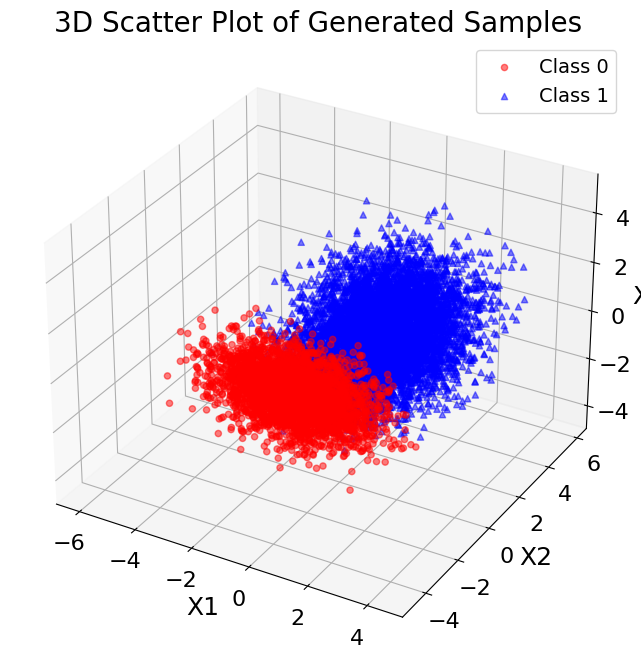

In [ ]:
# Parameters for the Gaussian components
gmm_params = {
    'mu': np.array([[-1, -1, -1, -1], [1, 1, 1, 1]]),
    'Sigma': [np.array([[2, -0.5, 0.3, 0],
                        [-0.5, 1, -0.5, 0],
                        [0.3, -0.5, 1, 0],
                        [0, 0, 0, 2]]),
              np.array([[1, 0.3, -0.2, 0],
                        [0.3, 2, 0.3, 0],
                        [-0.2, 0.3, 1, 0],
                        [0, 0, 0, 3]])],
    'priors': [0.35, 0.65]
}

# Generate samples using the pre-defined generate_data_from_gmm function
num_samples = 10000
samples, labels = generate_data_from_gmm(num_samples, gmm_params)

# Create a 3D scatter plot using the first three dimensions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot samples for each class with different colors
ax.scatter(samples[labels == 1, 0], samples[labels == 1, 1], samples[labels == 1, 2], c='r', marker='o', label='Class 0', alpha=0.5)
ax.scatter(samples[labels == 2, 0], samples[labels == 2, 1], samples[labels == 2, 2], c='b', marker='^', label='Class 1', alpha=0.5)

# Labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('3D Scatter Plot of Generated Samples')

# Display legend
ax.legend()

# Adjust the viewing angle
#ax.view_init(elev=20, azim=80)  # Change these values to adjust the angle

# Show plot
plt.show()

Question 1: Part A - subpart 1

Refer PDF Doc

Question 1: Part A - subpart 2

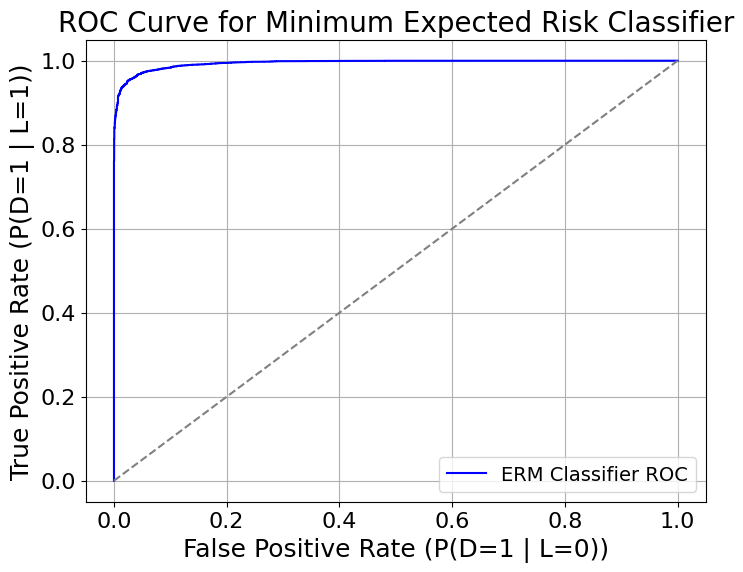

In [ ]:
# Ensure label alignment (convert to 0 and 1 for correct classification)
labels = np.where(labels == 1, 0, labels)
labels = np.where(labels == 2, 1, labels)

# Compute class conditional likelihoods using the correct logic
class_conditional_likelihoods = np.array([
    multivariate_normal.pdf(samples, mean=gmm_params['mu'][i], cov=gmm_params['Sigma'][i]) for i in range(2)
])

# Calculate the discriminant score using log likelihoods for better numerical stability
log_likelihood_ratio = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Generate the ROC curve
p10_values, p11_values = estimate_roc(log_likelihood_ratio, labels)

# Plot the final ROC curve
plt.figure(figsize=(8, 6))
plt.plot(p10_values, p11_values, label='ERM Classifier ROC', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel('False Positive Rate (P(D=1 | L=0))')
plt.ylabel('True Positive Rate (P(D=1 | L=1))')
plt.title('ROC Curve for Minimum Expected Risk Classifier')
plt.legend()
plt.grid(True)
plt.show()

Question 1: Part A - subpart 3

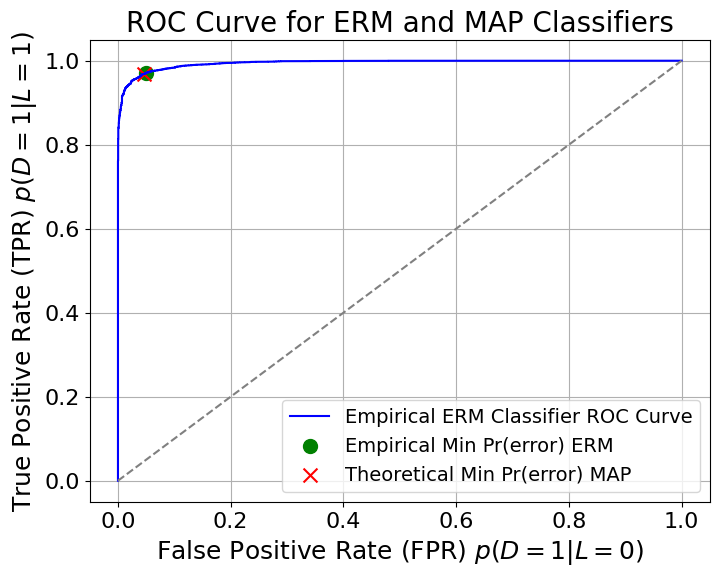

Min Empirical Pr(error) for ERM = 0.036
Min Empirical Threshold = 0.619
Min Theoretical Pr(error) for MAP = 0.037
Min Theoretical Threshold (MAP) = 0.538


In [ ]:
# Define class priors
P_L0 = gmm_params['priors'][0]  # P(L=0) = 0.35
P_L1 = gmm_params['priors'][1]  # P(L=1) = 0.65

# Generate the ROC curve
p10_values, p11_values = estimate_roc(log_likelihood_ratio, labels)

# Calculate the probability of error for each threshold (p(D=1|L=0) and p(D=0|L=1) weighted by priors)
P_error = P_L0 * p10_values + P_L1 * (1 - p11_values)

# Find the empirical minimum P(error) by identifying the threshold that minimizes error
min_error_index = np.argmin(P_error)
min_empirical_fpr = p10_values[min_error_index]
min_empirical_tpr = p11_values[min_error_index]
min_empirical_P_error = P_error[min_error_index]

# Compute theoretical gamma using the MAP rule (ratio of priors)
gamma_map = P_L0 / P_L1  # MAP threshold

# Make decisions using the MAP classification rule
decisions_map = log_likelihood_ratio >= np.log(gamma_map)

# Compute FPR and TPR for the MAP rule
class_metrics_map = get_binary_classification_metrics(decisions_map, labels)

# Calculate theoretical FPR and TPR
theoretical_fpr_map = class_metrics_map['FPR']
theoretical_tpr_map = class_metrics_map['TPR']

# Calculate the theoretical probability of error
min_theoretical_P_error = P_L0 * theoretical_fpr_map + P_L1 * (1 - theoretical_tpr_map)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(p10_values, p11_values, label='Empirical ERM Classifier ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line

# Mark the empirical minimum P(error)
plt.scatter(min_empirical_fpr, min_empirical_tpr, color='green', marker='o', label=f'Empirical Min Pr(error) ERM', s=100)

# Mark the theoretical minimum P(error) from MAP rule
plt.scatter(theoretical_fpr_map, theoretical_tpr_map, color='red', marker='x', label=f'Theoretical Min Pr(error) MAP', s=100)

# Add labels and title
plt.xlabel('False Positive Rate (FPR) $p(D=1 | L=0)$')
plt.ylabel('True Positive Rate (TPR) $p(D=1 | L=1)$')
plt.title('ROC Curve for ERM and MAP Classifiers')
plt.legend()
plt.grid(True)
plt.show()

# Print the minimum P(error) values and corresponding thresholds
print(f"Min Empirical Pr(error) for ERM = {min_empirical_P_error:.3f}")
print(f"Min Empirical Threshold = {np.log(gmm_params['priors'][1] / gmm_params['priors'][0]):.3f}")
print(f"Min Theoretical Pr(error) for MAP = {min_theoretical_P_error:.3f}")
print(f"Min Theoretical Threshold (MAP) = {gamma_map:.3f}")

Question 1: Part B

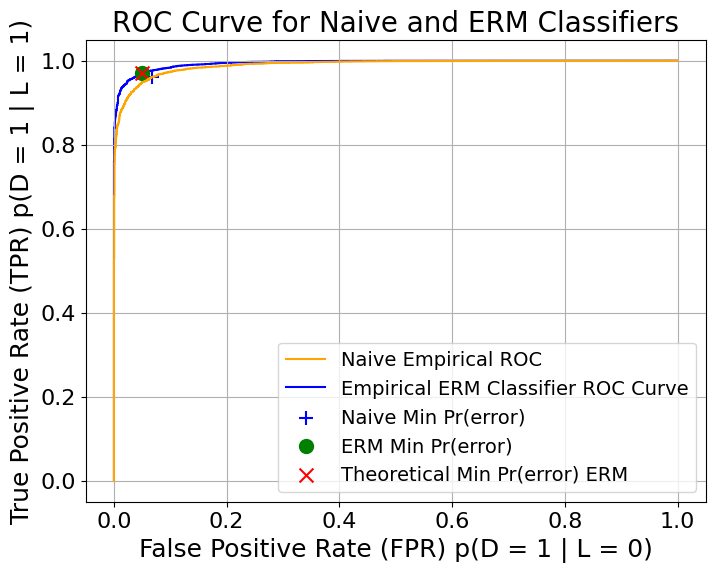

Min Naive Pr(error) = 0.049
Min Naive Threshold = 0.448


In [ ]:
# Compute class-conditional likelihoods for Naive Bayes (diagonal covariance) and ERM (true covariance)
naive_likelihoods = np.array([multivariate_normal.pdf(samples, gmm_params['mu'][l], np.eye(samples.shape[1])) for l in range(2)])
erm_likelihoods = np.array([multivariate_normal.pdf(samples, gmm_params['mu'][l], gmm_params['Sigma'][l]) for l in range(2)])

# Stabilize and normalize the log-likelihood ratio computation
epsilon = 1e-10  # Small constant to avoid log(0)
log_likelihood_ratio_naive = np.log(naive_likelihoods[1] + epsilon) - np.log(naive_likelihoods[0] + epsilon)
log_likelihood_ratio_erm = np.log(erm_likelihoods[1] + epsilon) - np.log(erm_likelihoods[0] + epsilon)

# Apply additional rescaling to improve interpretability of thresholds
log_likelihood_ratio_naive = (log_likelihood_ratio_naive - np.min(log_likelihood_ratio_naive)) / (np.max(log_likelihood_ratio_naive) - np.min(log_likelihood_ratio_naive))
log_likelihood_ratio_erm = (log_likelihood_ratio_erm - np.min(log_likelihood_ratio_erm)) / (np.max(log_likelihood_ratio_erm) - np.min(log_likelihood_ratio_erm))

# Sort discriminant scores to use as thresholds and generate ROC curves for both classifiers
naive_sorted_indices = np.argsort(log_likelihood_ratio_naive)
erm_sorted_indices = np.argsort(log_likelihood_ratio_erm)

# Sort both discriminant scores and labels accordingly
sorted_naive_scores = log_likelihood_ratio_naive[naive_sorted_indices]
sorted_erm_scores = log_likelihood_ratio_erm[erm_sorted_indices]
sorted_naive_labels = labels[naive_sorted_indices]
sorted_erm_labels = labels[erm_sorted_indices]

# Generate the ROC curves (FPR, TPR) for Naive and ERM classifiers
naive_roc_fpr, naive_roc_tpr = estimate_roc(log_likelihood_ratio_naive, labels)
erm_roc_fpr, erm_roc_tpr = estimate_roc(log_likelihood_ratio_erm, labels)

# Calculate the probability of error at each threshold
P_error_naive = P_L0 * naive_roc_fpr + P_L1 * (1 - naive_roc_tpr)
P_error_erm = P_L0 * erm_roc_fpr + P_L1 * (1 - erm_roc_tpr)

# Find minimum probability of error and corresponding thresholds
min_naive_P_error = np.min(P_error_naive)
min_naive_index = np.argmin(P_error_naive)
min_naive_threshold = sorted_naive_scores[min_naive_index]

min_erm_P_error = np.min(P_error_erm)
min_erm_index = np.argmin(P_error_erm)
min_erm_threshold = sorted_erm_scores[min_erm_index]

# Plot the ROC curve for both classifiers
plt.figure(figsize=(8, 6))
plt.plot(naive_roc_fpr, naive_roc_tpr, label='Naive Empirical ROC', color='orange', zorder=2)
plt.plot(erm_roc_fpr, erm_roc_tpr, label='Empirical ERM Classifier ROC Curve', color='blue', zorder=1)

# Mark the minimum Pr(error) for Naive Bayes and ERM classifiers
plt.scatter(naive_roc_fpr[min_naive_index], naive_roc_tpr[min_naive_index], color='blue', marker='+', s=100, label='Naive Min Pr(error)')
plt.scatter(erm_roc_fpr[min_erm_index], erm_roc_tpr[min_erm_index], color='green', marker='o', s=100, label='ERM Min Pr(error)')

# Ensure priors are defined properly
P_L0 = gmm_params['priors'][0]  # Prior for class 0
P_L1 = gmm_params['priors'][1]  # Prior for class 1
priors = np.array([P_L0, P_L1])  # Create an array of priors

# Add theoretical threshold and Pr(error) for ERM classifier
gamma_map = priors[1] / priors[0]
theoretical_fpr_erm = erm_roc_fpr[min_erm_index]  # Theoretical FPR
theoretical_tpr_erm = erm_roc_tpr[min_erm_index]  # Theoretical TPR

plt.scatter(theoretical_fpr_erm, theoretical_tpr_erm, color='red', marker='x', s=100, label='Theoretical Min Pr(error) ERM')

# Add labels, title, and legend
plt.xlabel('False Positive Rate (FPR) p(D = 1 | L = 0)')
plt.ylabel('True Positive Rate (TPR) p(D = 1 | L = 1)')
plt.title('ROC Curve for Naive and ERM Classifiers')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

print(f"Min Naive Pr(error) = {min_naive_P_error:.3f}")
print(f"Min Naive Threshold = {min_naive_threshold:.3f}")


Question 1: Part C

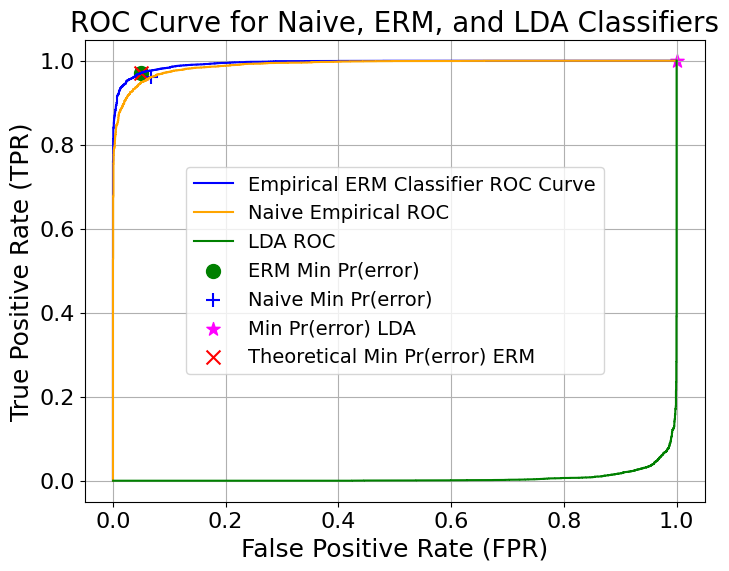

Min LDA Pr(error) = 0.350
Min LDA Threshold = 2.361


In [ ]:
# Step 1: Fisher LDA Classifier using sample average estimates
w_lda, lda_discriminant_score = perform_lda(samples, labels)

# Step 2: Estimate the ROC curve for this LDA classifier
lda_roc_fpr, lda_roc_tpr = estimate_roc(lda_discriminant_score, labels)

# Step 3: Compute the Probability of Error at Each Threshold for LDA
P_error_lda = P_L0 * lda_roc_fpr + P_L1 * (1 - lda_roc_tpr)

# Step 4: Find the minimum probability of error for LDA
min_lda_P_error = np.min(P_error_lda)
min_lda_index = np.argmin(P_error_lda)

# Ensure the threshold is real
min_lda_threshold = np.real(lda_discriminant_score[min_lda_index])  # Use real part of LDA threshold

# Step 5: Plotting the ROC curve for LDA Classifier
plt.figure(figsize=(8, 6))
plt.plot(erm_roc_fpr, erm_roc_tpr, label="Empirical ERM Classifier ROC Curve", color='blue')
plt.plot(naive_roc_fpr, naive_roc_tpr, label="Naive Empirical ROC", color='orange')
plt.plot(lda_roc_fpr, lda_roc_tpr, label="LDA ROC", color='green')

# Marking minimum probability of error for each classifier
plt.scatter(erm_roc_fpr[min_erm_index], erm_roc_tpr[min_erm_index], color='green', marker='o', s=100, label='ERM Min Pr(error)')
plt.scatter(naive_roc_fpr[min_naive_index], naive_roc_tpr[min_naive_index], color='blue', marker='+', s=100, label='Naive Min Pr(error)')
plt.scatter(lda_roc_fpr[min_lda_index], lda_roc_tpr[min_lda_index], color='magenta', marker='*', s=100, label="Min Pr(error) LDA")

# Marking theoretical minimum for ERM
plt.scatter(theoretical_fpr_erm, theoretical_tpr_erm, color='red', marker='x', s=100, label='Theoretical Min Pr(error) ERM')

# Adding labels, title, legend
plt.title('ROC Curve for Naive, ERM, and LDA Classifiers')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(True)

# Show final plot
plt.show()

# Printing minimum error and thresholds for LDA
print(f"Min LDA Pr(error) = {min_lda_P_error:.3f}")
print(f"Min LDA Threshold = {min_lda_threshold:.3f}")

Question 2

In [ ]:
def generate_data_from_gmm_modified(num_samples, gmm_params):
    # Determine dimensionality from mixture PDF parameters
    num_dimensions = gmm_params['mu'].shape[1]

    # Initialize arrays for samples and labels
    samples = np.zeros((num_samples, num_dimensions))
    labels = np.zeros(num_samples, dtype=int)

    # Randomly decide which samples will come from each component
    u = np.random.rand(num_samples)

    # Compute cumulative sum of priors (for thresholding)
    thresholds = np.cumsum(gmm_params['priors'])
    thresholds = np.insert(thresholds, 0, 0)  # Insert 0 at the start for easier thresholding

    # Loop through each component (class) to generate samples
    for component_idx in range(len(gmm_params['priors'])):
        # Find indices for which samples belong to the current component based on the thresholds
        component_mask = (u >= thresholds[component_idx]) & (u < thresholds[component_idx + 1])
        indices = np.where(component_mask)[0]

        # Assign labels based on the component index
        labels[indices] = component_idx

        # Sample data points from the Gaussian distribution
        if num_dimensions == 1:
            samples[indices, 0] = multivariate_normal.rvs(mean=gmm_params['mu'][component_idx][0],
                                                          cov=gmm_params['Sigma'][component_idx][0],
                                                          size=len(indices))
        else:
            samples[indices, :] = multivariate_normal.rvs(mean=gmm_params['mu'][component_idx],
                                                          cov=gmm_params['Sigma'][component_idx],
                                                          size=len(indices))

    return samples, labels


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

n = 3  # dimensionality of input random vectors
C = 3  # number of classes

# Define the Gaussian Mixture Model parameters
gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.3, 0.3, 0.4])

# Set the average standard deviation for generating the means
average_std = 1.0  # Average standard deviation

# Mean vectors for each class
mu_class1 = np.array([0, 0, 0])  # Class 1 mean
mu_class2 = np.array([2 * average_std, 2 * average_std, 2 * average_std])  # Class 2 mean
mu_class3 = np.array([3 * average_std, 3 * average_std, 3 * average_std])  # Class 3 mean

# Store the mean vectors in the GMM PDF parameters
gmm_pdf['mu'] = np.array([mu_class1, mu_class2, mu_class3])

# Setting covariance matrices to ensure significant overlap
covariance = 0.5 * np.eye(n)
gmm_pdf['Sigma'] = np.array([covariance, covariance, covariance])

Part A: subpart 1

[3012 2995 3993]


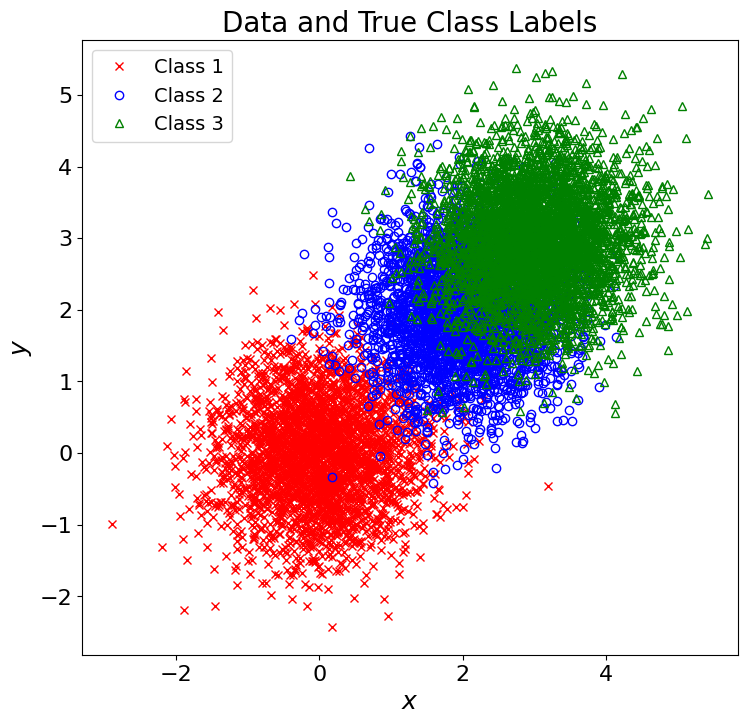

In [ ]:
# Sample generation function (using the corrected one)
num_samples = 10000
samples, labels = generate_data_from_gmm_modified(num_samples, gmm_pdf)

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in range(C)])
print(N_per_l)  # Ensure the correct number of samples per class

# Plot the original data and their true labels
fig, ax_gmm = plt.subplots(figsize=(8, 8))

# Plot each class with different markers and sizes to ensure visibility
ax_gmm.plot(samples[labels == 0, 0], samples[labels == 0, 1], 'rx', label="Class 1", markersize=6, markerfacecolor='none')
ax_gmm.plot(samples[labels == 1, 0], samples[labels == 1, 1], 'bo', label="Class 2", markersize=6, markerfacecolor='none')
ax_gmm.plot(samples[labels == 2, 0], samples[labels == 2, 1], 'g^', label="Class 3", markersize=6, markerfacecolor='none')

ax_gmm.set_xlabel(r"$x$")
ax_gmm.set_ylabel(r"$y$")
ax_gmm.set_aspect('equal')

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()
plt.show()

Question 2: Part A - subpart 2

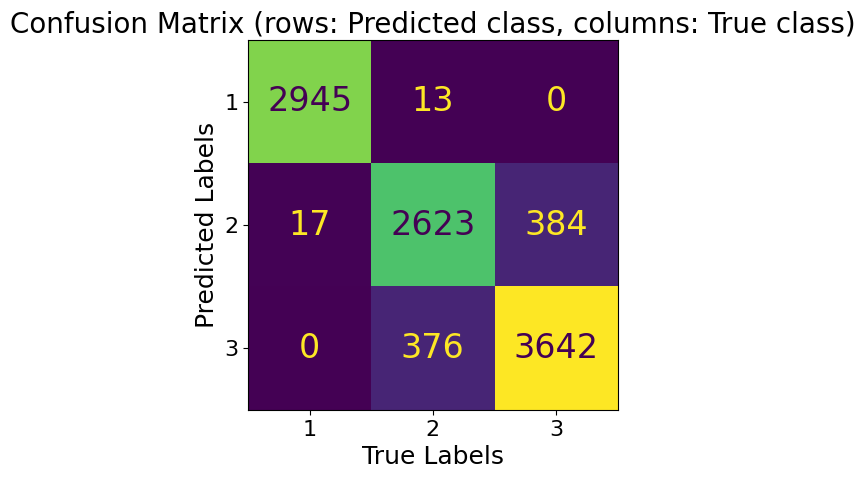

Total Number of Misclassified Samples: 790
Empirically Estimated Probability of Error: 0.0790


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lambda matrix for 0-1 loss for MAP decision rule
Lambda = np.ones((C, C)) - np.eye(C)  # C is the number of classes (3 in this case)

# Use the ERM decision rule based on minimum conditional risk
decisions = perform_erm_classification(samples, Lambda, gmm_pdf, C)

# Compute the confusion matrix to estimate P(D=i|L=j)
conf_matrix = confusion_matrix(labels, decisions)

# Display the confusion matrix
conf_display = ConfusionMatrixDisplay(conf_matrix, display_labels=[1, 2, 3])
conf_display.plot(colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")
plt.title("Confusion Matrix (rows: Predicted class, columns: True class)")
plt.show()

# Calculate the number of correctly classified samples
correct_class_samples = np.sum(np.diag(conf_matrix))

# Calculate the number of misclassified samples and empirical probability of error
num_misclassified = num_samples - correct_class_samples
prob_error = num_misclassified / num_samples

print(f"Total Number of Misclassified Samples: {num_misclassified}")
print(f"Empirically Estimated Probability of Error: {prob_error:.4f}")

Question 2: Part A - subpart 3

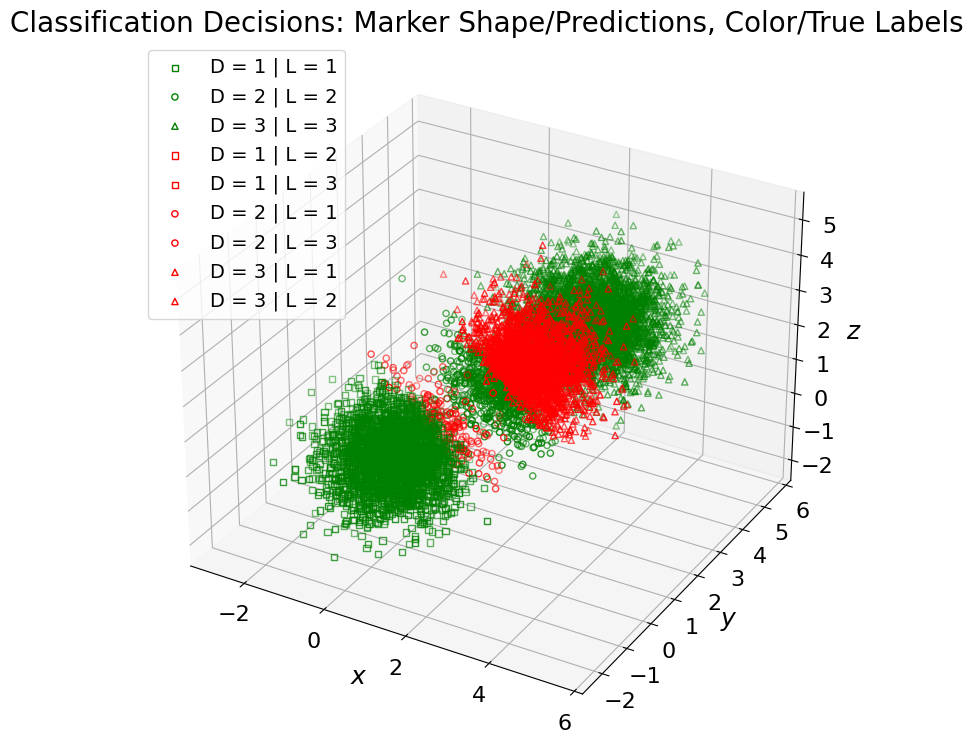

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig_map_3d = plt.figure(figsize=(8, 8))
ax = fig_map_3d.add_subplot(111, projection='3d')

marker_shapes = ['s', 'o', '^']  # Square, Circle, Triangle

# Plot the correct classifications first (green markers)
for r in L:  # Each decision option
    for c in L:  # Each class label
        ind_rc = np.argwhere((decisions == r) & (labels == c))

        if r == c:  # Correct classification
            marker = marker_shapes[r]
            color = 'g'
            ax.scatter(samples[ind_rc, 0], samples[ind_rc, 1], samples[ind_rc, 2],
                       marker=marker, color=color, label="D = {} | L = {}".format(r + 1, c + 1), facecolors='none')

# Plot the incorrect classifications last (red markers)
for r in L:  # Each decision option
    for c in L:  # Each class label
        ind_rc = np.argwhere((decisions == r) & (labels == c))

        if r != c:  # Incorrect classification
            marker = marker_shapes[r]
            color = 'r'
            ax.scatter(samples[ind_rc, 0], samples[ind_rc, 1], samples[ind_rc, 2],
                       marker=marker, color=color, label="D = {} | L = {}".format(r + 1, c + 1), facecolors='none')

ax.legend()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")
ax.set_title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

Question 2: Part B
Λ10

Confusion Matrix (rows: Predicted class, columns: True class):
Total Number of Misclassified Samples: 1352
Empirically Estimated Probability of Error: 0.1352


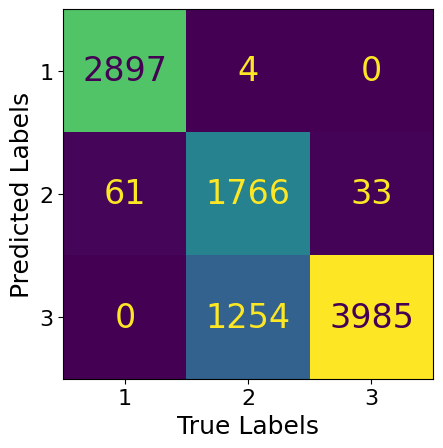

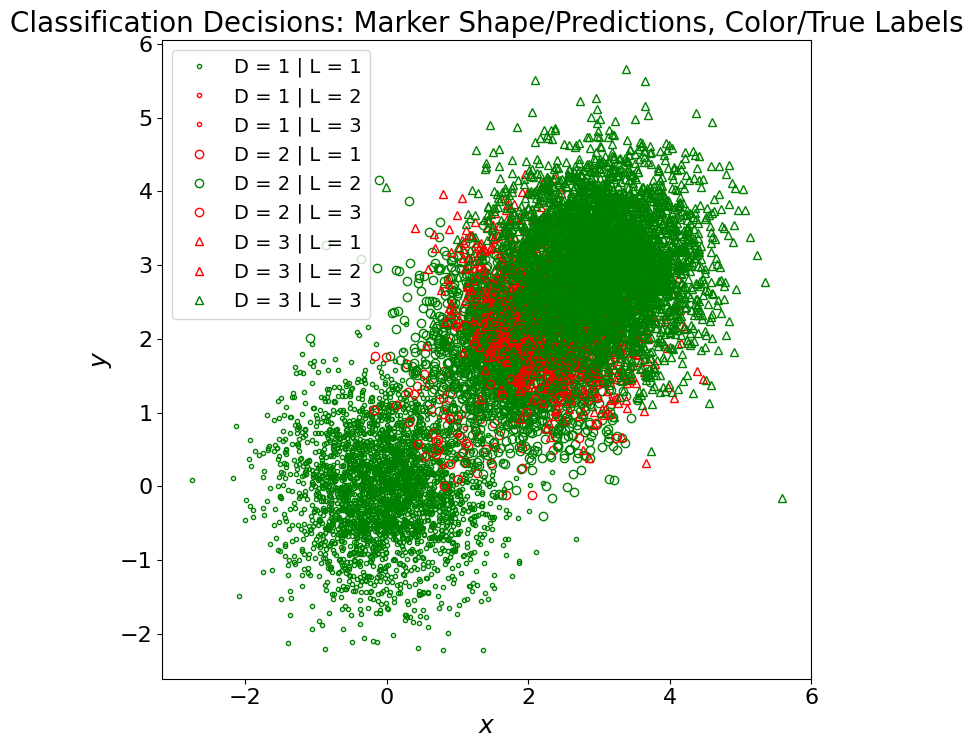

In [ ]:
# Define the Lambda matrix for λ_10
Lambda = np.array([[0, 10, 10],
                   [1, 0, 10],
                   [1, 1, 0]])

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(samples, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_mat))
print(f"Total Number of Misclassified Samples: {num_samples - correct_class_samples}")

prob_error = 1 - (correct_class_samples / num_samples)
print(f"Empirically Estimated Probability of Error: {prob_error:.4f}")

# Plot for decisions vs true labels
fig_erm = plt.figure(figsize=(8, 8))

marker_shapes = '.o^s'

for r in range(C):  # Each decision option
    for c in range(C):  # Each class label
        ind_rc = np.argwhere((decisions == r) & (labels == c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(samples[ind_rc, 0], samples[ind_rc, 1], marker, label=f"D = {r+1} | L = {c+1}", markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(samples[ind_rc, 0], samples[ind_rc, 1], marker, label=f"D = {r+1} | L = {c+1}", markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

Question 2: Part B Λ100

Confusion Matrix (rows: Predicted class, columns: True class):
Total Number of Misclassified Samples: 2553
Empirically Estimated Probability of Error: 0.2553


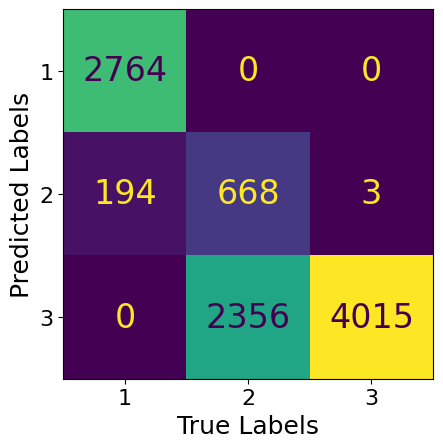

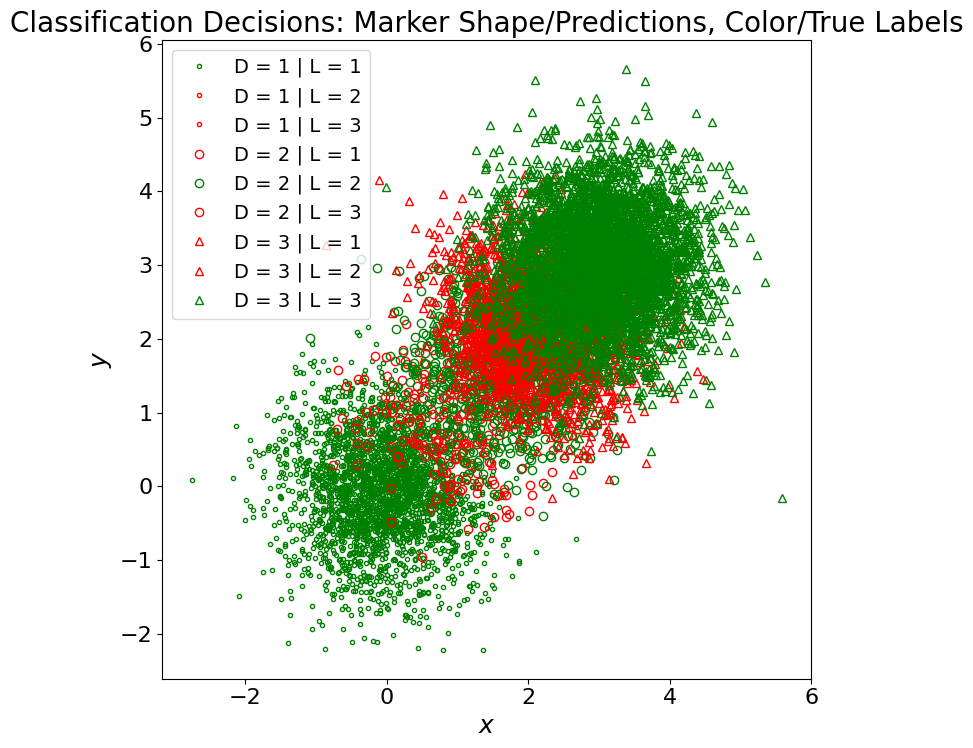

In [ ]:
# Define the Lambda matrix for λ_100
Lambda = np.array([[0, 100, 100],
                   [1, 0, 100],
                   [1, 1, 0]])

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(samples, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_matrix = confusion_matrix(decisions, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_matrix))
print(f"Total Number of Misclassified Samples: {num_samples - correct_class_samples}")

prob_error = 1 - (correct_class_samples / num_samples)
print(f"Empirically Estimated Probability of Error: {prob_error:.4f}")

# Plot for decisions vs true labels
fig_erm = plt.figure(figsize=(8, 8))

marker_shapes = '.o^s'

for r in range(C):  # Each decision option
    for c in range(C):  # Each class label
        ind_rc = np.argwhere((decisions == r) & (labels == c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(samples[ind_rc, 0], samples[ind_rc, 1], marker, label=f"D = {r+1} | L = {c+1}", markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(samples[ind_rc, 0], samples[ind_rc, 1], marker, label=f"D = {r+1} | L = {c+1}", markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

Question 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Specify the path to the 'winequality-white.csv' file
file_path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/Homework_1/wine+quality/winequality-white.csv'

# Load the dataset using pandas
wine_df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataframe
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
from sklearn import preprocessing

def regularized_covariance_matrix(X, lambda_reg):
    n = X.shape[0]
    cov_matrix = np.cov(X)
    cov_matrix += lambda_reg * np.eye(n)
    return cov_matrix

# Total number of rows/samples
num_samples = len(wine_df.index)

# Extracting data matrix X and target labels vector
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(qualities)
class_labels = label_encoder.transform(qualities)

# Estimate class priors
gmm = {}
gmm['priors'] = (wine_df.groupby(['quality']).size() / num_samples).to_numpy()

# Infer number of classes
num_classes = len(gmm['priors'])

# Infer number of features
n = X.shape[1]

# Compute the class means and covariances
gmm['mu'] = wine_df.groupby(['quality']).mean().to_numpy()
gmm['Sigma'] = np.array([regularized_covariance_matrix(X[class_labels == l].T, (1/n)) for l in range(num_classes)])

samples_per_class = np.array([sum(class_labels == l) for l in range(num_classes)])
print(samples_per_class)

[  20  163 1457 2198  880  175    5]


Confusion Matrix (rows: Predicted class, columns: True class):
Total Number of Misclassified Samples: 2309
Empirically Estimated Probability of Error: 0.4714


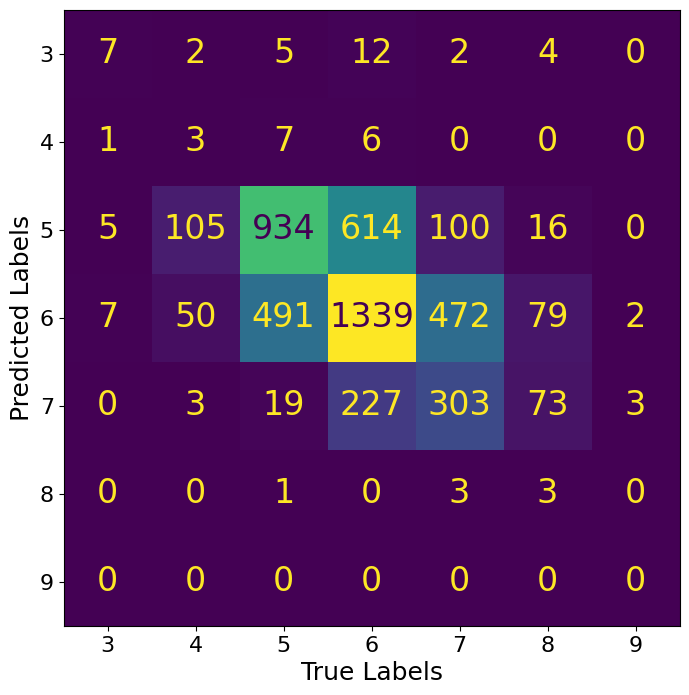

In [ ]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, class_labels, ax=ax,
                                                       display_labels=['3', '4', '5', '6', '7', '8', '9'],
                                                       colorbar=False)

plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Number of Misclassified Samples: {:d}".format(num_samples - correct_class_samples))

prob_error = 1 - (correct_class_samples / num_samples)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

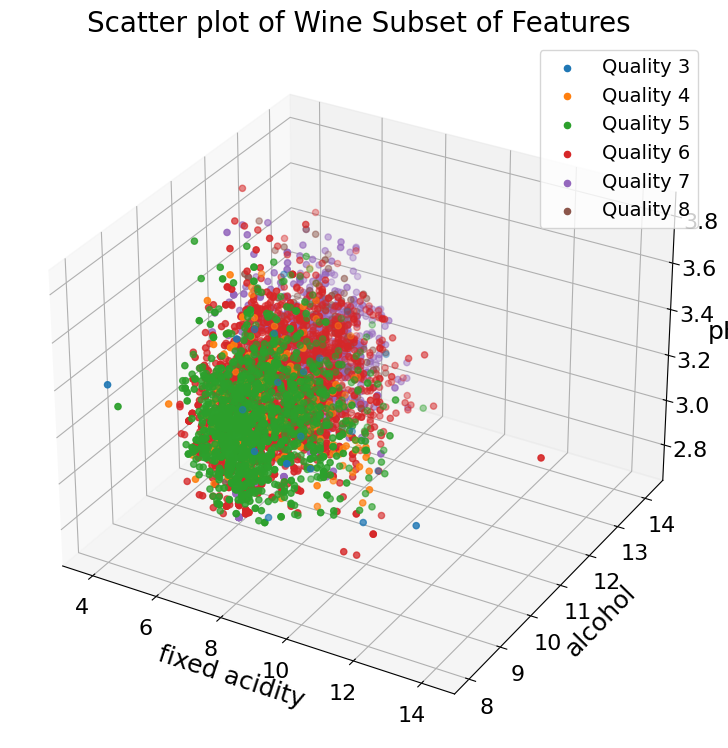

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax_subset = fig.add_subplot(111, projection='3d')

unique_qualities = np.sort(wine_df['quality'].unique())
for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_subset.scatter(wine_df[wine_df['quality']==q]['fixed acidity'],
                      wine_df[wine_df['quality']==q]['alcohol'],
                      wine_df[wine_df['quality']==q]['pH'],
                      label="Quality {}".format(q))

ax_subset.set_xlabel("fixed acidity")
ax_subset.set_ylabel("alcohol")
ax_subset.set_zlabel("pH")

plt.title("Scatter plot of Wine Subset of Features")
plt.legend()
plt.tight_layout()
plt.show()

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


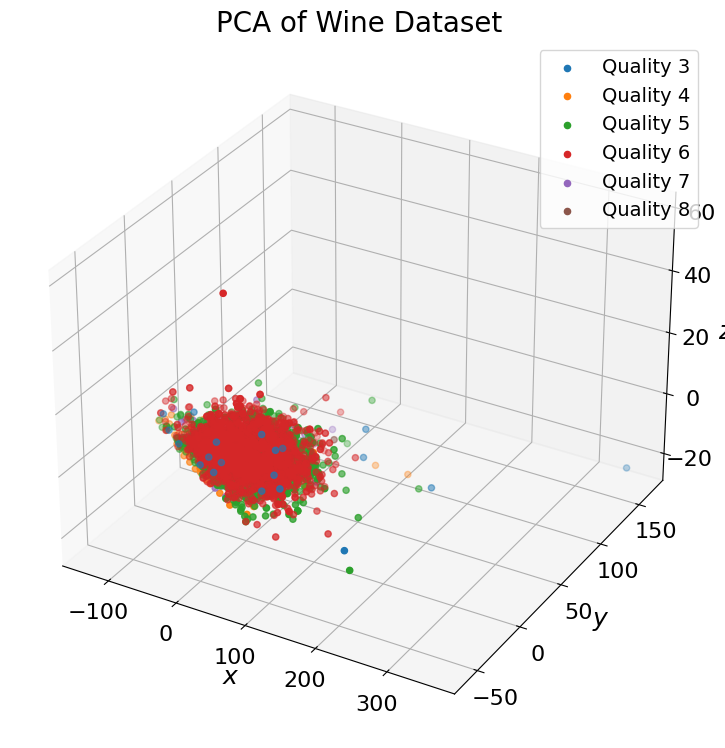

In [ ]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(8, 8))
ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[wine_df['quality']==q, 0], Z[wine_df['quality']==q, 1], Z[wine_df['quality']==q, 2],
                   label="Quality {}".format(q))

ax_pca.set_xlabel(r"$x$")
ax_pca.set_ylabel(r"$y$")
ax_pca.set_zlabel(r"$z$")

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Reads zip file without writing to disk by emulating the file using a BytesIO buffer class
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip')
har_zip = ZipFile(BytesIO(resp.read()))
har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)
har_df = pd.concat([har_train_df, har_test_df])

har_df

<ipython-input-177-b47e5db08c38>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
<ipython-input-177-b47e5db08c38>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
2943,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
2944,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
2945,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


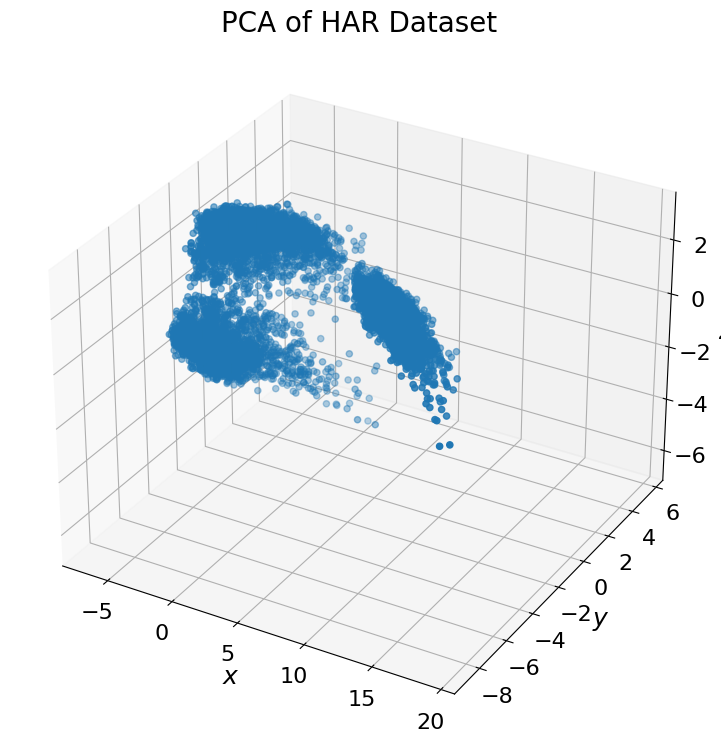

In [ ]:
X = har_df.to_numpy()

fig = plt.figure(figsize=(8, 8))
ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

ax_pca.scatter(Z[:, 0], Z[:, 1], Z[:, 2])

ax_pca.set_xlabel(r"$x$")
ax_pca.set_ylabel(r"$y$")
ax_pca.set_zlabel(r"$z$")

plt.title("PCA of HAR Dataset")
plt.tight_layout()
plt.show()